# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
dog_files

array(['/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06826.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06871.jpg', ...,
       '/data/dog_images/valid/100.Lowchen/Lowchen_06682.jpg',
       '/data/dog_images/valid/100.Lowchen/Lowchen_06708.jpg',
       '/data/dog_images/valid/100.Lowchen/Lowchen_06684.jpg'], 
      dtype='<U106')

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


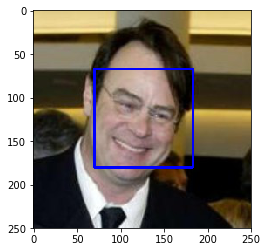

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Among all human images we detected 98% faces and among all dog images about 17% of faces were detected.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

true_human = 0
true_dog = 0

for i in tqdm(range(100)):
    if face_detector(human_files_short[i]):
        true_human += 1
    if face_detector(dog_files_short[i]):
        true_dog += 1

print('Human Files: %human faces detected = {:5f}'.format(true_human/100))
print('Dog Files: %human faces detected = {:5f}'.format(true_dog/100))

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]

Human Files: %human faces detected = 0.980000
Dog Files: %human faces detected = 0.170000


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 78052158.36it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # load color (BGR) image
    img = Image.open(img_path)
    # normalize
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),  # to make non-square images fit
        transforms.ToTensor(),          # standardizes to [0,1] as well
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    img = data_transforms(img)
    # add batch dimension as dummy
    img = img.unsqueeze(0)
    
    # prediciton step and extract class index
    if use_cuda:
        img = img.cuda()
        
    prediction = VGG16(img)
    
    if use_cuda:
        prediction = prediction.cpu()
    idx = prediction.data.numpy().argmax() 
    
    return idx # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    breed = VGG16_predict(img_path)
    return (breed >= 151) and (breed <=268)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
About 1% of images in human_files_short and 100% of images in dog_files_short have a detected dog.

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
true_human = 0
true_dog = 0

for i in tqdm(range(100)):
    if dog_detector(human_files_short[i]):
        true_human += 1
    if dog_detector(dog_files_short[i]):
        true_dog += 1

print('Human Files: %dogs detected = {:5f}'.format(true_human/100))
print('Dog Files: %dogs detected = {:5f}'.format(true_dog/100))

100%|██████████| 100/100 [00:07<00:00, 14.17it/s]

Human Files: %dogs detected = 0.010000
Dog Files: %dogs detected = 1.000000


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch
import glob
import os
import cv2          
import numpy as np
import matplotlib.pyplot as plt                        
%matplotlib inline  
from torchvision import datasets, transforms
# to avoid truncate error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# torch.manual_seed(1984)

data_dir  = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir  = os.path.join(data_dir, 'test/')

# transformations to augment the images
train_data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

raw_data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_data_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_data_transform)
raw_data = datasets.ImageFolder(train_dir, transform=raw_data_transform)

# define dataloader
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
raw_loader  = torch.utils.data.DataLoader(raw_data, batch_size=batch_size, shuffle=False)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# check shape of images
#raw_loader = torch.utils.data.DataLoader(raw_data, batch_size=batch_size, shuffle=False)

too_small = 0
for img_path in dog_files:
    img = cv2.imread(img_path)
    if img.shape[0] < 199 or img.shape[1] < 199:
        print(img.shape, img_path)
        too_small += 1
print('Total too small', too_small)

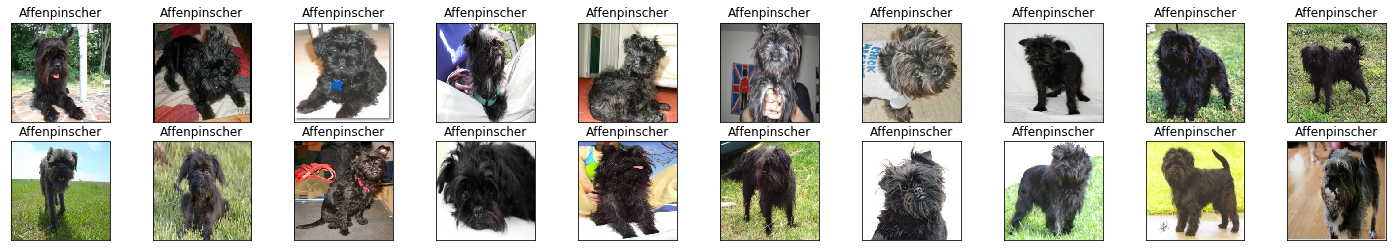

In [2]:
classes = [item[27:-1] for item in sorted(glob.glob('/data/dog_images/train/*/'))]
# classes

dataiter = iter(raw_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(min(batch_size, 20)):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: Resize to 224x224 which is also the vgg15 input size to have better performance comparison (by resizing as images seem to of very different shape). Augmentation by horizontal flipping and random rotation to have some degree of variation but avoid upside down images (very different from test cases). Finally, a normalization of pixel values.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # input (224, 224)    
        self.conv1 = nn.Conv2d(  3,  64, 3, padding=1)
        self.conv2 = nn.Conv2d( 64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(7 * 7 * 256, 1000)
        self.fc2   = nn.Linear(1000, 500)
        self.fc3   = nn.Linear(500, 133)
        self.drop  = nn.Dropout(p=0.3)    
    
    def forward(self, x):
        # Convolution Layers - Feature Maps
        x = self.conv1(x)
        x = F.relu(self.pool(x)) # 112 x 112
        
        x = self.conv2(x)
        x = F.relu(self.pool(x)) # 56 x 56
        
        x = self.conv3(x)
        x = F.relu(self.pool(x)) # 28 x 28
        
        x = self.conv4(x)
        x = F.relu(self.pool(x)) # 14 x 14
        
        x = self.conv5(x)
        x = F.relu(self.pool(x)) # 7 x 7

        # Classification Layers
        x = x.view(-1, 7 * 7 * 256)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ The neural net has the typical structure of, first, several convolutional layers (with increasing channels) and combined with maxpooling to create feature maps, then second, the classification part implemented with 3 dense layers. The topology is guided by the paper of Simonyan, Zisserman, 2015, on 'Very Deep Convolutional Networks for Large-Scale Image Recognition'. Dropout layers reduce the tendency of overfitting.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [8]:
from tqdm import tqdm

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss)) 
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss)) 
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss), save_path)
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
            
    # return trained model
    return model


In [19]:
# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                     criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.882775 	Validation Loss: 4.874159
Validation loss decreased (inf --> 4.874159).  Saving model ... model_scratch.pt
Epoch: 2 	Training Loss: 4.758156 	Validation Loss: 4.699181
Validation loss decreased (4.874159 --> 4.699181).  Saving model ... model_scratch.pt
Epoch: 3 	Training Loss: 4.575248 	Validation Loss: 4.565222
Validation loss decreased (4.699181 --> 4.565222).  Saving model ... model_scratch.pt
Epoch: 4 	Training Loss: 4.418465 	Validation Loss: 4.384127
Validation loss decreased (4.565222 --> 4.384127).  Saving model ... model_scratch.pt
Epoch: 5 	Training Loss: 4.266993 	Validation Loss: 4.276762
Validation loss decreased (4.384127 --> 4.276762).  Saving model ... model_scratch.pt
Epoch: 6 	Training Loss: 4.128971 	Validation Loss: 4.196285
Validation loss decreased (4.276762 --> 4.196285).  Saving model ... model_scratch.pt
Epoch: 7 	Training Loss: 4.001355 	Validation Loss: 4.093141
Validation loss decreased (4.196285 --> 4.093141).  Saving mod

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [6]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [20]:
# call test function    
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.716374


Test Accuracy: 15% (126/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [9]:
## TODO: Specify data loaders
import torch
import os          
import numpy as np
import matplotlib.pyplot as plt                        
from torchvision import datasets, transforms
from PIL import ImageFile

%matplotlib inline  

# to avoid truncate error
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

data_dir  = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir  = os.path.join(data_dir, 'test/')

# transformations to augment the images
train_data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_data_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_data_transform)

# define dataloader
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

# Freezing training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# adjust final classification layer to expected size
model_transfer.classifier[6] = nn.Linear(4096, 133)

for param in model_transfer.classifier.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model_transfer.cuda()

In [6]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The basis is the VGG16 pretrained model which shows overall good performance in image recoginition. The 'feature' part of the model weights are frozen to avoid general retraining and leaving weight canges only to the classification part. The final classification layer (output layer) is changed to the number of dog breed classes (133)


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [3]:
import torch.optim as optim

### select loss function
criterion_transfer = nn.CrossEntropyLoss()

### select optimizer / train only classifier parameters
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
# train the model
n_epochs = 5

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.963844 	Validation Loss: 1.106330
Validation loss decreased (inf --> 1.106330).  Saving model ... model_transfer.pt
Epoch: 2 	Training Loss: 1.917062 	Validation Loss: 0.989824
Validation loss decreased (1.106330 --> 0.989824).  Saving model ... model_transfer.pt
Epoch: 3 	Training Loss: 1.801205 	Validation Loss: 1.082989
Epoch: 4 	Training Loss: 1.803990 	Validation Loss: 1.135736
Epoch: 5 	Training Loss: 1.876270 	Validation Loss: 1.024796


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [10]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.062647


Test Accuracy: 73% (614/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [11]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image


# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer.eval()

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
# class_names = [item for item in train_data.classes]


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # to make non-square images fit
    transforms.ToTensor(),          # standardizes to [0,1] as well
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    # normalize

    img = data_transforms(img)
    # add batch dimension as dummy
    img = img.unsqueeze(0)
    
    # prediciton step and extract class index
    if use_cuda:
        img = img.cuda()
        
    prediction = model_transfer(img)
    
    if use_cuda:
        prediction = prediction.cpu()
    idx = prediction.data.numpy().argmax() 
    
    return class_names[idx] # predicted class index

In [42]:
predict_breed_transfer('/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04199.jpg')

'Doberman pinscher'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [25]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt                        
%matplotlib inline  

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    print("-------------------------------")
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if face_detector(img_path):
        print("Hello, Human!")
    elif dog_detector(img_path):
        print("Hello, Dog!")
    else:
        print("Oh, who are you? I cannot recognize you :-(")
        return
    
    print("You look like a ", predict_breed_transfer(img_path))
    return 


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The overall distinction between humans and dogs seems to work relatively reliable. However, the dog breed identification is still not good enough. We suggest the following improvements:
* To improve the model performance of model_transfer more labelled data on dog breed images would certainly be benefitial. At the moment we use only a limited number of images for training
* Training data could also be furhter cleaned. Some images also include humans next to dogs which might create noise for the CNN
* Maybe a further tuning (number of cells per layer, number of layers) of the classification layers within model_transfer CNN could also lead to a performance increase
* Other images recognition CNNs could be tested for performance comparison to find a better base model for transfer learning
* Fine-tuning could be another approach to improve the existing model_transfer CNN. This would however need more compute time and also would benefit from more training data.
* Radically, a complete re-training of the adjusted VGG network could also lead to better performance. For this approach a larger training dataset is a must

In [ ]:
from glob import glob

new_images = glob('./upload/*')

for img_path in new_images:
    run_app(img_path)